In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout
from tensorflow.keras.activations import relu, linear, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

from tqdm import tqdm
import os 

tqdm.pandas()

# my Helper functions

from HelperFunctions import *

In [2]:
landsat_training_data = pd.read_csv('../Datasets/landsat_features_training.csv')
terra_climate_training_data = pd.read_csv('../Datasets/terraclimate_features_training.csv')
explained_variables = pd.read_csv('../Datasets/water_quality_training_dataset.csv')

joined_explaining_vars = combine_two_datasets(landsat_training_data, terra_climate_training_data)
full_dataset = combine_two_datasets(joined_explaining_vars, explained_variables)

full_dataset

target_columns = ['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']
feature_columns = full_dataset.columns.drop(target_columns + ['Sample Date', 'Latitude', 'Longitude'])

Feature_data = full_dataset[feature_columns]
#Target_data = full_dataset[target_columns]

Target_data = full_dataset['Total Alkalinity']

X_train, X_test, y_train, y_test = train_test_split(Feature_data, Target_data, test_size=0.15)

X_train

,nir,green,swir16,swir22,NDMI,MNDWI,pet
2203,14203.0,10694.0,15062.00,12002.50,-0.029352,-0.169592,163.20000
5618,14579.0,10764.0,16846.00,14394.00,-0.072140,-0.220283,230.70000
2759,12443.5,9179.0,10952.00,9548.50,0.063752,-0.088073,235.40001
8156,9257.5,9651.0,9015.50,8739.00,0.013244,0.034045,201.50000
6816,18427.5,9835.0,16300.00,12876.00,0.061263,-0.247369,183.90001
...,...,...,...,...,...,...,...
1842,15667.0,9794.0,14180.50,10960.00,0.049803,-0.182965,155.90001
3653,17263.5,8993.0,11338.00,8868.00,0.207174,-0.115341,124.10000
996,16790.5,10436.0,14786.00,12244.00,0.063481,-0.172468,166.70000
2089,14183.0,9801.0,13704.25,11265.25,0.021549,-0.167901,130.00000


## XGBoost model, no normalization, no more features ---->>> ta dando overfeating sinistro

In [4]:
import xgboost as xgb 
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
# nao normalizar saída

In [5]:
boost_predicter = xgb.XGBRegressor(
    objective ='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2,
)

history = boost_predicter.fit(
    X_train,
    y_train,
    verbose=True,
    eval_set=[(X_test, y_test)]
)






[0]	validation_0-rmse:73.54382
[1]	validation_0-rmse:72.53212
[2]	validation_0-rmse:71.71094
[3]	validation_0-rmse:70.99594
[4]	validation_0-rmse:70.39954
[5]	validation_0-rmse:69.83967
[6]	validation_0-rmse:69.38214
[7]	validation_0-rmse:68.99633
[8]	validation_0-rmse:68.66111
[9]	validation_0-rmse:68.38060
[10]	validation_0-rmse:68.11352
[11]	validation_0-rmse:67.88167
[12]	validation_0-rmse:67.64493
[13]	validation_0-rmse:67.45975


[14]	validation_0-rmse:67.27257
[15]	validation_0-rmse:67.14378
[16]	validation_0-rmse:67.01120
[17]	validation_0-rmse:66.87674
[18]	validation_0-rmse:66.77803
[19]	validation_0-rmse:66.67326
[20]	validation_0-rmse:66.58333
[21]	validation_0-rmse:66.50559
[22]	validation_0-rmse:66.43801
[23]	validation_0-rmse:66.33376
[24]	validation_0-rmse:66.25199
[25]	validation_0-rmse:66.20466
[26]	validation_0-rmse:66.17381
[27]	validation_0-rmse:66.12659
[28]	validation_0-rmse:66.08694
[29]	validation_0-rmse:66.01251
[30]	validation_0-rmse:65.98300
[31]	validation_0-rmse:65.95638
[32]	validation_0-rmse:65.88422
[33]	validation_0-rmse:65.82389
[34]	validation_0-rmse:65.79188
[35]	validation_0-rmse:65.73527
[36]	validation_0-rmse:65.65987
[37]	validation_0-rmse:65.62015
[38]	validation_0-rmse:65.56839
[39]	validation_0-rmse:65.51855
[40]	validation_0-rmse:65.49963
[41]	validation_0-rmse:65.45253
[42]	validation_0-rmse:65.40963
[43]	validation_0-rmse:65.36677
[44]	validation_0-rmse:65.32781
[45]	val

In [6]:
y_pred = boost_predicter.predict(X_test)
evaluate_model(y_pred, y_test, dataset_name=' all data_test boosted tree')


 all data_test boosted tree Evaluation:
R²: 0.266
RMSE: 63.991


(array([119.50251 , 155.26872 ,  79.2737  , ..., 130.74557 , 124.967384,
        122.00866 ], dtype=float32),
 0.26550563879228717,
 np.float64(63.991124036918045))

## Testing Submission Data, no normalization, no more features

In [7]:
submission_landsat_data = pd.read_csv("../Datasets/landsat_features_validation.csv")
submission_terra_climate_data = pd.read_csv("../Datasets/terraclimate_features_validation.csv")

all_submission_data_before = combine_two_datasets(submission_landsat_data, submission_terra_climate_data)

combine_two_datasets(submission_landsat_data, submission_terra_climate_data)

all_submission_data = all_submission_data_before[feature_columns]
all_submission_data


,nir,green,swir16,swir22,NDMI,MNDWI,pet
0,15229.0,12868.0,14797.0,12421.0,0.014388,-0.069727,161.900010
1,14525.5,9493.5,12425.5,9973.0,0.081427,-0.130571,177.600000
2,16221.0,9304.5,12536.5,9958.0,0.128123,-0.147979,158.400010
3,14525.5,9493.5,12425.5,9973.0,0.081427,-0.130571,130.000000
4,9125.0,11100.5,9455.0,8711.0,-0.017761,0.080052,152.500000
...,...,...,...,...,...,...,...
195,17562.0,9492.0,13559.5,10235.0,0.128609,-0.176453,171.400010
196,15883.0,9083.5,12135.5,9484.0,0.133751,-0.143833,159.400010
197,13619.5,10046.5,13105.0,10969.0,0.019252,-0.132108,168.600000
198,13955.5,10670.0,17303.5,14835.5,-0.107105,-0.237135,81.200005


In [99]:
submission_pred = boost_predicter.predict(all_submission_data)

predicted_values_pd = pd.DataFrame({
    'Total Alkalinity': submission_pred[:, 0], 
    'Electrical Conductance': submission_pred[:, 1], 
    'Dissolved Reactive Phosphorus': submission_pred[:, 2]
})

predicted_coords_data_pd = pd.DataFrame({
    'Latitude': all_submission_data_before['Latitude'].values,
    'Longitude': all_submission_data_before['Longitude'].values,
    'Sample Date': all_submission_data_before['Sample Date'].values,
})

submission_predicted_pd = pd.concat([predicted_coords_data_pd, predicted_values_pd], axis=1)

submission_predicted_pd.to_csv("../Results/submission_predictions_boosted_tree.csv", index=False)
submission_predicted_pd

,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus
0,-32.043333,27.822778,01-09-2014,96.757721,397.926117,34.234299
1,-33.329167,26.077500,16-09-2015,132.410675,565.819458,66.910934
2,-32.991639,27.640028,07-05-2015,82.229500,415.662445,38.098866
3,-34.096389,24.439167,07-02-2012,77.547523,249.922180,24.442152
4,-32.000556,28.581667,01-10-2014,91.228127,284.725128,36.027863
...,...,...,...,...,...,...
195,-33.771111,25.386667,06-12-2012,129.569199,496.444916,55.545643
196,-33.185361,27.390750,04-09-2014,79.285316,422.053131,34.476128
197,-32.043333,27.822778,28-09-2015,138.925537,505.890106,38.969879
198,-33.001667,25.161389,08-01-2015,133.857254,426.944824,47.294914


## Learning Curve ( see overfitting )

In [8]:
import yellowbrick.model_selection as ms

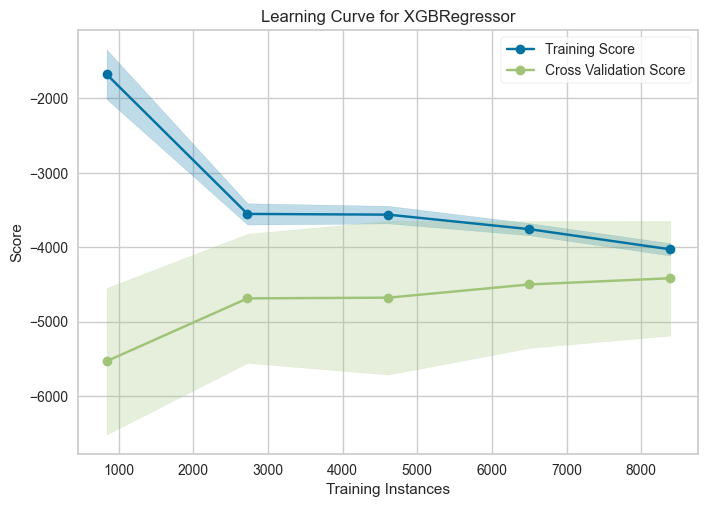

In [9]:
_ = ms.learning_curve(boost_predicter, Feature_data, Target_data, scoring='neg_mean_squared_error', cv=10)

## Feature Importance

<Axes: >

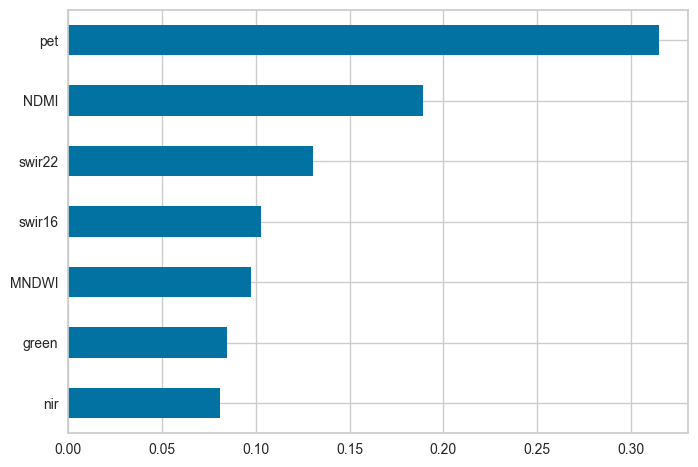

In [10]:
(pd.Series(boost_predicter.feature_importances_, index = X_train.columns).sort_values().plot.barh())

## Tunning

In [11]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from typing import Dict, Union, Any

def hyperparameter_tuning(space: Dict[str, Union[float, int]], X_train: pd.DataFrame, 
                          y_train: pd.Series,
                          n_estimators: int=1500, 
                          metric:callable=cross_val_score) -> Dict[str, Any]:
    
    '''Perforn hyperparaneter tuning for an XGBoost classifier. This function takes a dictionary of
    hyperparameters, training and test data, and an optional value for early stopping rounds, and 
    returns a dictionary with the loss and model resulting from the tuning process. 
    The model is trained using the training data and evaluated on the test data. 
    The loss is computed as the negative of the accuracy score. 
    Parameters space : Dict[str, Union[float, int]]

    X_train : pd.DataFrame

    The training data.'''
    
    int_vals = ['max_depth', 'reg_alpha', 'n_estimators']
    
    space = {k :(int(val) if k in int_vals else val) for k, val in space.items()}
    
    #space['early_stopping_rounds'] = early_stopping_rounds
    space['n_estimators'] = n_estimators
    
    model = xgb.XGBRegressor(objective='reg:squarederror', **space)
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    model.fit(X_train, y_train, eval_set=evaluation, verbose=False)
    
    pred=model.predict(X_test)
    
    score = metric(
        estimator = model,
        X=X_train,
        y=y_train,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    avg_mse_loss = -score.mean() 
    
    return {'loss': avg_mse_loss, 'status': STATUS_OK, 'model': model}



## Bruteforce

In [12]:
params = {'random_state': 42}

# Lista de dicionários, onde cada item é um "round" de otimização
# Cada round define o espaço de busca para um subconjunto de hiperparâmetros
rounds = [
    # Round 1: Parâmetros da Estrutura da Árvore
    {'max_depth': hp.quniform('max_depth', 3, 8, 1), # tree: profundidade máxima (inteiro entre 1 e 8)
     'min_child_weight': hp.loguniform('min_child_weight', -2, 4)}, # min_child_weight (escala logarítmica)
    # Round 2: Parâmetros de Subamostragem (Stochastic)
    {'subsample': hp.uniform('subsample', 0.5, 1), # subsample: fração de amostras por árvore (entre 0.5 e 1.0)
     'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)}, # colsample: fração de colunas por árvore (entre 0.5 e 1.0)

    # Round 3: Regularização L1 e L2
    {'reg_alpha': hp.uniform('reg_alpha', 0, 10), # L1
     'reg_lambda': hp.uniform('reg_lambda', 1, 12)}, # L2
     
    # Round 4: Gamma (regularização adicional de perda mínima para split)
    {'gamma': hp.loguniform('gamma', -5, 2.3)}, # regularization (escala logarítmica)
    
    # Round 5: Taxa de Aprendizado
    {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.1))} # boosting (escala logarítmica, de e^-7 a e^0)
]

all_trials = []
for round in rounds:
    # Combina os parâmetros fixos com o espaço de busca do round atual
    # Ex: Na primeira iteração, params = {'random_state': 42, 'max_depth': ..., 'min_child_weight': ...}
    params = {**params, **round}
    
    # Objeto para registrar o histórico de tentativas do Hyperopt
    trials = Trials()
    
    # Chama a função principal de otimização Bayesiana
    best = fmin(
        # fn: função a ser minimizada (aqui, a perda do modelo)
        # lambda space: cria uma função anônima que passa o espaço de parâmetros para hyperparameter_tuning
        fn=lambda space: hyperparameter_tuning(space, X_train, y_train),
        
        # space: O espaço de busca atual (combinação de parâmetros fixos e variáveis)
        space=params,
        
        # algo: Algoritmo de otimização (TPE é o mais comum para Bayesiana)
        algo=tpe.suggest,
        
        # max_evals: número de iterações para testar neste round
        max_evals=80,
        
        # trials: onde o histórico de resultados será armazenado
        trials=trials,
    )
    
    # Atualiza 'params' para a próxima iteração: 
    # Fixa os melhores valores encontrados (contidos em 'best') para o próximo round
    params = {**params, **best}
    
    # Armazena o objeto Trials completo
    all_trials.append(trials)

100%|██████████| 80/80 [04:02<00:00,  3.03s/trial, best loss: 2829.5057071710044]


In [17]:
params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = 1200
#params['learning_rate'] = 0.05
#params['gamma'] = 2
#params['min_child_weight'] = 8

params

{'random_state': 42,
 'max_depth': 5,
 'min_child_weight': np.float64(1.130633388049782),
 'subsample': np.float64(0.9899226454344163),
 'colsample_bytree': np.float64(0.976220870948009),
 'reg_alpha': np.float64(6.482005696755514),
 'reg_lambda': np.float64(9.438952113505934),
 'gamma': np.float64(0.05139105744593399),
 'learning_rate': np.float64(0.08663011330074663),
 'n_estimators': 1200}

In [18]:
optimized_model = xgb.XGBRegressor(**params)

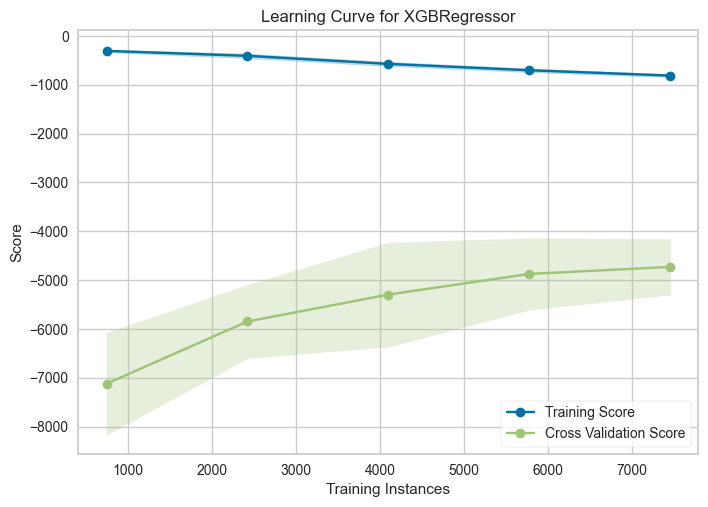

In [19]:


_ = ms.learning_curve(optimized_model, Feature_data, Target_data, scoring='neg_mean_squared_error', cv=5)

## Feature Importance of optimized model

[0]	validation_0-rmse:73.80974
[1]	validation_0-rmse:72.43853
[2]	validation_0-rmse:71.27348
[3]	validation_0-rmse:70.61784
[4]	validation_0-rmse:70.04327
[5]	validation_0-rmse:69.16227
[6]	validation_0-rmse:68.42464
[7]	validation_0-rmse:67.69713
[8]	validation_0-rmse:66.96643
[9]	validation_0-rmse:66.46424
[10]	validation_0-rmse:66.02513
[11]	validation_0-rmse:65.49795
[12]	validation_0-rmse:65.11343
[13]	validation_0-rmse:64.67155
[14]	validation_0-rmse:64.36818
[15]	validation_0-rmse:64.13068
[16]	validation_0-rmse:63.79697
[17]	validation_0-rmse:63.54950
[18]	validation_0-rmse:63.33219
[19]	validation_0-rmse:63.17733
[20]	validation_0-rmse:62.91073
[21]	validation_0-rmse:62.76106
[22]	validation_0-rmse:62.60139
[23]	validation_0-rmse:62.42805
[24]	validation_0-rmse:62.26043
[25]	validation_0-rmse:62.16892
[26]	validation_0-rmse:62.04544
[27]	validation_0-rmse:61.91985
[28]	validation_0-rmse:61.82421
[29]	validation_0-rmse:61.74328
[30]	validation_0-rmse:61.60265
[31]	validation_0-

<Axes: >

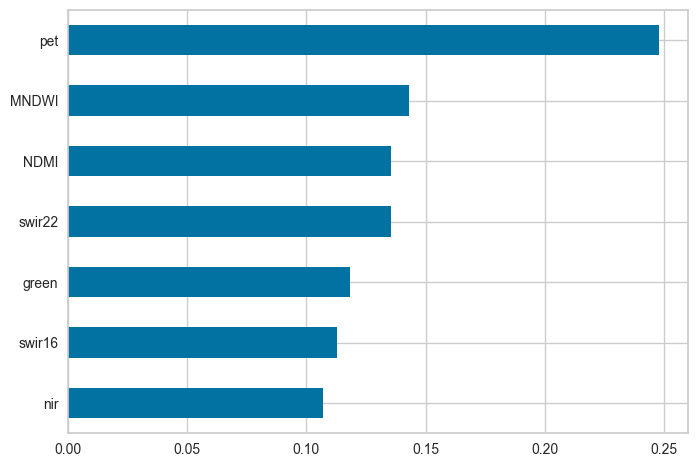

In [20]:
optimized_model.fit(
    X_train,
    y_train,
    verbose=True,
    eval_set=[(X_test, y_test)],
)
(pd.Series(optimized_model.feature_importances_, index = X_train.columns).sort_values().plot.barh())

In [21]:
evaluate_model(optimized_model.predict(X_test), y_test, dataset_name=' all data_test optimized boosted tree, target_feature = Water Alkalinity')
evaluate_model(optimized_model.predict(X_train), y_train, dataset_name=' all data_train optimized boosted tree, target_feature = Water Alkalinity')


 all data_test optimized boosted tree, target_feature = Water Alkalinity Evaluation:
R²: 0.553
RMSE: 49.918

 all data_train optimized boosted tree, target_feature = Water Alkalinity Evaluation:
R²: 0.841
RMSE: 29.765


(array([ 79.5211  , 215.13812 ,  28.002533, ..., 187.92574 ,  47.62626 ,
        101.00958 ], dtype=float32),
 0.84119493022313,
 np.float64(29.764841834724074))